<a href="https://colab.research.google.com/github/Carhuacusma/CC61_PDI_Trabajo_Final/blob/main/CC61_PDI_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CC61: Procesamiento de Imágenes
# **Trabajo Final**

Alumnos:
* Galván Díaz, Joaquín Adrían : u201810A.
* Moreno Carhuacusma, Dante Brandon : u201818067

## Objetivos

* Distinguir una partitura musical en una imagen
* Extraer el sonido que correspone a los símbolos en la partitura
* Determinar el mejor acercamiento con técnicas de procesamiento de imágenes al problema

## Planteamiento (Borrador porque no estoy seguro del formato xd)

### Preprocesamiento

Todas las imágenes cargadas pasan por un método para "rectificarlas", asumiendo que podrían ser fotos de partituras impresas, desde diversos ángulos.

1. Si no está en escala de grises, convertir a escala de grises.
2. Blur: Aplica filtro bilateral gaussiano sobre la imagen en escala de grises para facilitar el proceso de *edge detection*.
3. Edge Detection: Aplica el filtro Canny a la imagen resultante.
4. Código de la Cadena: Aplica la función findCountours de OpenCV para la detección de contornos con el código de la cadena. Retorna un arreglo de contornos con los puntos que componen a cada uno.
5. Ordena el arreglo de contornos obtenido según el área.

![Imagen de una hoja impresa](https://raw.githubusercontent.com/Carhuacusma/CC61_PDI_Trabajo_Final/main/Data/Fotos/mary_hoja.jpg)

Para extraer la posible hoja de la imagen y rectificarla, considera los siguientes parámetros
- $contornos$: Arreglo del 15% de contornos con mayor área, los que podrían ser una hoja.
- $areaTotal$: Área de la imagen filtrada.
- $umbralHoja$: Un umbral para determinar cuál debe ser la proporción hoja/imagen mínima y así evitar amplificar cuadrados pequeños en imágenes de partituras ideales.

Entonces
* Por cada *contorno* $C$ en el arreglo $contornos$:
> * $approx \gets$ Polígono Aproximado del contorno $C$, con método de OpenCV
> * Si el polígono aproximado $approx$ es de 4 esquinas:
>> - $auxArea \leftarrow$ Área de $approx$ 
>> - Si $\frac{auxArea}{areaTotal} > umbralHoja:$
>>> - $candidatoHoja \gets approx$
>>> - *break for*

En el caso en que $candidatoHoja$ no tenga valor, se asume que la imagen ingresada es una imagen ideal, y no se realiza la transformación geométrica para corregir la perspectiva y considerar únicamente la región dentro de la hoja impresa.

### Extracción de lineas: Transformada de Hough

Se aplica la transformada de Hough para extraer las líneas en la partitura, aunque no se puede estar seguro de que la orientación sea la correcta.

El método $HoughLinesP$ de cv2 retorna un arreglo donde cada línea se representa por las coordenadas de sus puntos extremos.
Este arreglo pasa por la función $hacerDFdeLineas$, que como su nombre describe, busca crear un DataFrame de las líneas, con los atributos: Punto 1, Punto 2, Longitud, Ángulo.

Punto 1 se define como el punto extremo de la línea más cercano al origen de coordenadas. La longitud es la distancia euclidiana entre estos puntos extremos, y el ángulo es el arco tangente de la pendiente entre estas dos líneas.

Con los ángulos de cada línea se puede definir la orientación para mejorar la orientación de la imagen. Sin embargo, el preprocesamiento no es perfecto.
Las líneas detectadas pueden no ser todas del pentagrama; mientras que otras pueden ser solo un segmento de una línea cortada por una nota en medio. Además, el ángulo calculado puede no ser el mismo entre las líneas del pentagrama

Para considerar los posibles errores del cálculo de ángulos, se dividió el círculo trigonométrico en 8 secciones. De estos, se nombran 4 sectores, representados gráficamente en la Figura 2:

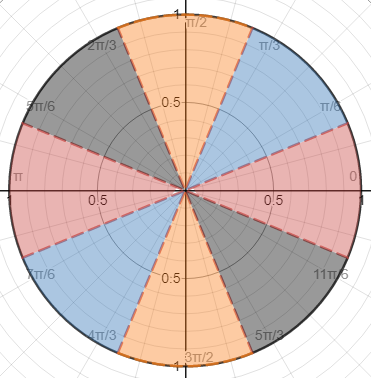

*Figura 2: Círculo trigonométrico divido en 8 secciones*

Donde:
* En el sector rojo, o primer sector, de $-\frac{\pi}{8}$ rad a $\frac{\pi}{8}$ rad se ubicarían líneas horizontales, a pesar de que el caso perfecto sean los $0$ rad.
* El segundo sector, de celeste, ubica a las líneas diagonales, que son un caso que se espera sea raro. Se descartan como posibles líneas del pentagrama, a no ser que no exista otro candidato, forzando otra transformación geométrica a la imagen para rectificar. Está en el rango de $\frac{3\pi}{8}$ rad a $\frac{5\pi}{8}$
* El tercer sector, de naranja, ubica líneas verticales. Si las líneas del pentagrama están en este sector, simplemente se necesita rotar en 90° a la imagen. Está en el rango de $\frac{5\pi}{8}$ rad a $\frac{7\pi}{8}$
* El cuarto sector, de negro, es el otro sector con líneas diagonales que podría forzar una transformación geométrica. Está en el rango de $\frac{7\pi}{8}$ rad a $\frac{9\pi}{8}$

Debido al funcionamiento del método *arctan()* de *numpy*, los resultados estarán en el primer y cuarto cuadrante convencional del círculo trigonométrico. Sin embargo, para evitar complicaciones en la diferencia de ángulos, se convertirán todos los resultados al dominio $-\frac{\pi}{8}$ a $\frac{9\pi}{8}$

## Desarrollo

### Importación de librerías

In [ ]:
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from skimage import io
from google.colab.patches import cv2_imshow

In [ ]:
#No da error en colab pero no funciona el import {simbolo de exclamcion} pip install scikits.audiolab

In [ ]:
#from scikits.audiolab import play

### Cargar Imágenes

In [ ]:
repo = "https://raw.githubusercontent.com/Carhuacusma/CC61_PDI_Trabajo_Final/main/Data/"

In [ ]:
#repo = "Data/"

In [ ]:
ruta = "Fotos/mary_hoja.jpg"
imHoja = io.imread("%s%s"%(repo,ruta))
print(type(imHoja))

<class 'numpy.ndarray'>


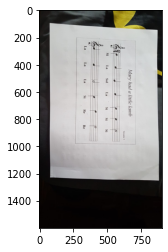

In [ ]:
plt.imshow(imHoja)

In [ ]:
ruta = "Ideal/mary_had_a_little_lamb.jpg"
imIdeal = io.imread("%s%s"%(repo,ruta))
print(type(imIdeal))

<class 'numpy.ndarray'>


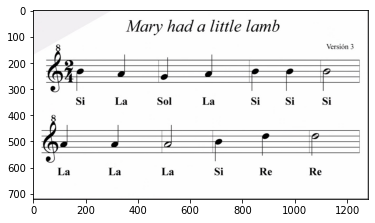

In [ ]:
plt.imshow(imIdeal)

### Preprocesamiento

In [ ]:
def ordenarEsquinas(pts):
    rect = np.zeros((4, 2), dtype = "float32") # Rectángulo de 0s para ser como un canvas
    oAux = pts.sum(axis = 1) # Arreglo de 4 resultados...................................... : oAux[i] = pts[i][0] + pts[i][1]
    rect[0] = pts[np.argmin(oAux)] # La esquina superior izquierda tiene la suma más pequeña
    rect[2] = pts[np.argmax(oAux)] # La esquina inferior derecha tiene la mayor suma
    oAux = np.diff(pts, axis = 1)  # ....................................................... : oAux[i] = |(pts[i][0] - pts[i][1])|
    rect[1] = pts[np.argmin(oAux)] # La esquina superior derecha minima diferencia (X mayor)
    rect[3] = pts[np.argmax(oAux)] # La esquina inferior izquierda maxima diferencia
    return rect

In [ ]:
def warping(imagen, topL, topR, botR, botL):
    widthA = np.sqrt(((botR[0] - botL[0]) ** 2) + ((botR[1] - botL[1]) ** 2)) #.... | Distancia euclidiana
    widthB = np.sqrt(((topR[0] - topL[0]) ** 2) + ((topR[1] - topL[1]) ** 2)) #.... | ""
    heightA = np.sqrt(((topR[0] - botR[0]) ** 2) + ((topR[1] - botR[1]) ** 2)) #... | ""
    heightB = np.sqrt(((topL[0] - botL[0]) ** 2) + ((topL[1] - botL[1]) ** 2)) #... | ""
    maxWidth = max(int(widthA), int(widthB)) #......... | El anchos máximo se usa para la nueva imagen
    maxHeight = max(int(heightA), int(heightB)) #...... | El alto máximo se usa para la nueva imagen
    #.................................................. | dst: Puntos de destino, imagen "recta"
    dst = np.array([[0, 0],
                    [maxWidth - 1, 0],
                    [maxWidth - 1, maxHeight - 1],
                    [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(np.array([topL,topR,botR,botL]), dst) #......... Matriz de transformación
    return cv2.warpPerspective(imagen, M, (maxWidth, maxHeight)) #.................. Aplicar la matriz para obtener la imagen nueva

In [ ]:
def enCasoHoja(imagen,contornos,umbralHoja = 0.5):
    contornos = contornos[:int(0.15*len(contornos))] #........ 1. Extrae el 15 % de contornos con mayor área
    candHoja = []
    auxArea = 0
    for c in contornos: #..................................... 2. Por cada C que pertenece a Contornos:
        perimetro = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * perimetro, True) #......2.1. Disminuir el número de lados de C (Polígono Aproximado)
        if len(approx) == 4: #.......................................2.2. Si el polígono aproximado es de 4 lados:
            auxArea = cv2.contourArea(approx) #................................ Considera el Área del "candidato a hoja"
            if auxArea/((imagen.shape[0])*(imagen.shape[1])) > umbralHoja: #... Si la proporción de las áreas candidato/imagen supera el umbral:
                candHoja = approx #................................................... "Candidato" es la hoja impresa
                break
    if len(candHoja) == 0:
        print("Imagen ideal")
        return imagen
    else:
        puntos = candHoja.reshape(4, 2) #... Para manejar mejor los puntos
        rect = ordenarEsquinas(puntos) #.... Ordena las esquinas a formato:
        (tl, tr, br, bl) = rect #........... Sentido Horario, Esquinas: Superior Izquierda, Superior Derecha,...
        print("Foto con esquinas")
        return warping(imagen,topL=tl,topR=tr,botR=br,botL=bl)

In [ ]:
def rectificar_parte_1(imagen, umbralHoja = 0.5):
    if len(imagen.shape) != 2:
        imagen = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY) #....................| 1. Asegura Escala de Grises, 
    imagen = cv2.bilateralFilter(imagen,d=3,sigmaColor=75,sigmaSpace=30) # .| 2. Blur, 
    im_canny = cv2.Canny(imagen,50,205) #...................................| 3. Edge Detector: Canny >> Imagen con bordes
    #............. Extraer la hoja impresa de la foto:
    contornos, _ = cv2.findContours(im_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #...| 1. Extrae "Contornos" con Cadena (findContours) 
    contornos = sorted(contornos, key = cv2.contourArea, reverse = True) #..............| 2. Ordenar "Contornos" por Área
    imagen = enCasoHoja(im_canny,contornos,umbralHoja) #................................| 3. Imagen de la hoja impresa 
    #............. Rectificar la orientación
    # TODO: Hough de Líneas,
    # -> Flip x° para que el pentagrama encaje  
    return imagen

### Líneas

In [ ]:
#Si definimos "mayor" como el punto más alejado del centro de coordenadas
def p1Mayor_p2(punto1, punto2):
  s1 = punto1[0] + punto1[1]
  s2 = punto2[0] + punto2[1]
  return s1 > s2

In [ ]:
class Linea:
  def __init__(self, punto_1, punto_2):
    def corregirAngulo(angulo):
      if angulo < -(np.pi / 8):
        angulo += np.pi
      return round(angulo*100) / 100
    if p1Mayor_p2(punto_1, punto_2):
      aux = punto_1
      punto_1 = punto_2
      punto_2 = aux
    self.punto1 = punto_1
    self.punto2 = punto_2
    dx = punto_2[0] - punto_1[0]
    dy = punto_2[1] - punto_1[1]
    theta = np.pi / 2 #......................... Línea vertical, (dx = 0)
    if dx != 0: #............................... para evitar la división entre 0
      theta = np.arctan(dy/dx) #................ >> Asigna el angulo que corresponde.
    self.angulo = corregirAngulo(theta)
    tam = pow((dx ** 2) + (dy ** 2), 0.5) #..... Distancia euclidiana para el tamaño
    self.longitud = round(tam*10)/10 #............... Redondea la distancia
    #self.direccion = [self.punto2[0] - self.punto1[0],self.punto2[1] - self.punto1[0]] # Redundante perhaps
  
  def __str__(self):
    res  = "Punto 1 : %s\nPunto2 : %s\n"%(self.punto1, self.punto2)
    res += "Longitud: %s\n"%self.longitud
    res += "Angulo de Pendiente: %s"%self.angulo
    return res
  
  def difAngulos(self, otra, valabs = True):
    if not valabs or self.angulo > otra.angulo:
      return self.angulo - otra.angulo
    return otra.angulo - self.angulo
  
  def alineadoCon(self, otra, umbral):
    if self.difAngulos(otra) > umbral:
      return False, self
    aux = Linea(self.punto1,otra.punto2)
    if self.difAngulos(aux) < 0.15 and otra.difAngulos(aux) < 0.15:
      return True, aux
    else:
      return False, aux

  def intersectaCon(self, otra):
    if self.angulo == otra.angulo:
      return False
    

In [ ]:
0.04*180/np.pi

2.291831180523293

In [ ]:
aux1 = Linea([0,0],[2,3])
aux2 = Linea([2.57,3.66],[4.23,6.26])
print(aux1.alineadoCon(aux2,0.4))

(True, <__main__.Linea object at 0x7f383bbf9d68>)


In [ ]:
class Pentagrama:
  def __init__(self, lineas):
    self.lineas = lineas

In [ ]:
def hacerDFdeLineas(lineas):
    if lineas is None:
        print("No hay líneas")
        return None
    def valores(p1,p2):
      sp1 = p1[0] + p1[1]
      sp2 = p2[0] + p2[1]
      if sp2 < sp1:
        aux = p1
        p1 = p2
        p2 = p1
      dx = p2[0] - p1[0]
      dy = p2[1] - p1[1]
      theta = np.pi / 2
      if dx != 0:
        theta = np.arctan(dy/dx)
      theta = round(theta*100) / 100
      tam = pow((dx ** 2) + (dy ** 2), 0.5)
      tam = round(tam*10)/10
      return [p1,p2,tam,theta]
    dfLineas = []
    arrLineas = []
    for linea in lineas:
        l = linea[0] #Acceder a los valores porque linea = [[x1 y1 x2 y2]]
        dfLineas.append(valores([l[0],l[1]], [l[2],l[3]]))
        arrLineas.append( Linea([l[0],l[1]], [l[2],l[3]]))
    return pd.DataFrame(data=dfLineas,columns=["Punto 1", "Punto 2", "Longitud", "Angulo"]), arrLineas

EN PROCESO: #aka TODO, lo que está fuera luego se meterá dentro, pero ir probando que funciones 

In [ ]:
def discriminarPentagramas(dfLineas):
    #TODO: Asumimos que será en formato de HoughLinesP por lo de x,y,dist y ang creo
    #...... Punto 1, Punto 2, Longitud, Angulo
    #......
    def distEuclidiana(punto1, punto2):
      dx = punto2[0] - punto1[0]
      dy = punto2[1] - punto1[1]
      return pow((dx ** 2) + (dy ** 2),0.5)
    lineas = dfLineas.sort_values(by='Punto 1').values
    for linea in lineas:
      dist = linea[]
      linea[3]
    return 0

In [ ]:
r_imHoja = rectificar_parte_1(imHoja,0.5)
linesP = cv2.HoughLinesP(r_imHoja, 1, np.pi / 180, 50, None, 50, 10)
dfLineasP,_ = hacerDFdeLineas(linesP)

Foto con esquinas


In [ ]:
auxImHoja = r_imHoja.copy()
auxImHoja = cv2.cvtColor(auxImHoja,cv2.COLOR_GRAY2BGR)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(auxImHoja,(l[0],l[1]),(l[2],l[3]),(0,0,255),3)

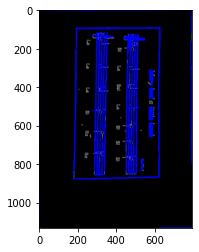

In [ ]:
plt.imshow(auxImHoja)

In [ ]:
dfLineasP.head()

,Punto 1,Punto 2,Longitud,Angulo
0,"[300, 114]","[300, 114]",0.0,1.57
1,"[190, 488]","[190, 488]",0.0,1.57
2,"[351, 128]","[351, 128]",0.0,1.57
3,"[313, 114]","[313, 114]",0.0,1.57
4,"[321, 336]","[321, 336]",0.0,1.57


In [ ]:
dfLineasP.sort_values(by='Angulo')

,Punto 1,Punto 2,Longitud,Angulo
240,"[274, 524]","[342, 513]",68.9,-0.16
226,"[441, 139]","[502, 133]",61.3,-0.10
223,"[294, 401]","[348, 397]",54.1,-0.07
232,"[466, 508]","[519, 505]",53.1,-0.06
258,"[469, 510]","[519, 507]",50.1,-0.06
...,...,...,...,...
104,"[495, 576]","[495, 576]",0.0,1.57
105,"[508, 667]","[508, 667]",0.0,1.57
106,"[481, 381]","[481, 381]",0.0,1.57
93,"[483, 600]","[483, 600]",0.0,1.57


In [ ]:
0.93 * 180 / np.pi

53.285074947166564

In [ ]:
dfPorPuntos = dfLineasP.sort_values(by='Punto 1')
print(len(dfPorPuntos))

277


In [ ]:
n = len(dfPorPuntos)
df_Pinned = [False for _ in range(n)]
df_LineaPentagrama = [False for _ in range(n)]
dfVerdaderasLineas = []
for i in range(n-1):
  maybePentagrama = []
  for j in range(i+1,n):
    linea1 = dfPorPuntos.iloc[i]
    linea2 = dfPorPuntos.iloc[j]
    if abs(linea1["Angulo"] - linea2["Angulo"]) > 0.4: #..... Orientación diferente: No son parte
      continue
    else: #.................................................. Misma orientacion
      auxLinea = Linea(linea1["Punto 1"],linea2["Punto 2"])
      if abs(auxLinea.theta - linea1[""])

In [ ]:
print(type(dfPorPuntos.iloc[0]["Angulo"]))

<class 'numpy.float64'>


In [ ]:
dfPorLongitud = pd.DataFrame(data=dfPorLongitud.values,columns=["Punto 1","Punto 2","Longitud","Angulo"])
dfPorLongitud.head()

,Punto 1,Punto 2,Longitud,Angulo
0,"[1, 633]","[1, 583]",50,1.57
1,"[315, 857]","[314, 807]",50,1.55
2,"[549, 154]","[499, 152]",50,0.04
3,"[303, 717]","[304, 667]",50,-1.55
4,"[519, 507]","[469, 510]",50.1,-0.06


In [ ]:
dfPorLongitud.iloc[0]["Angulo"]

1.57

In [ ]:
dfPorLongitud.values[0]

array([list([1, 633]), list([1, 583]), 50.0, 1.57], dtype=object)

In [ ]:
linesH = cv2.HoughLines(r_imHoja,0.7,np.pi/180,100)

In [ ]:
auxImH = r_imHoja.copy()
auxImH = cv2.cvtColor(r_imHoja,cv2.COLOR_GRAY2BGR)
for rho,theta in linesH[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(auxImH,(x1,y1),(x2,y2),(0,0,255),2)

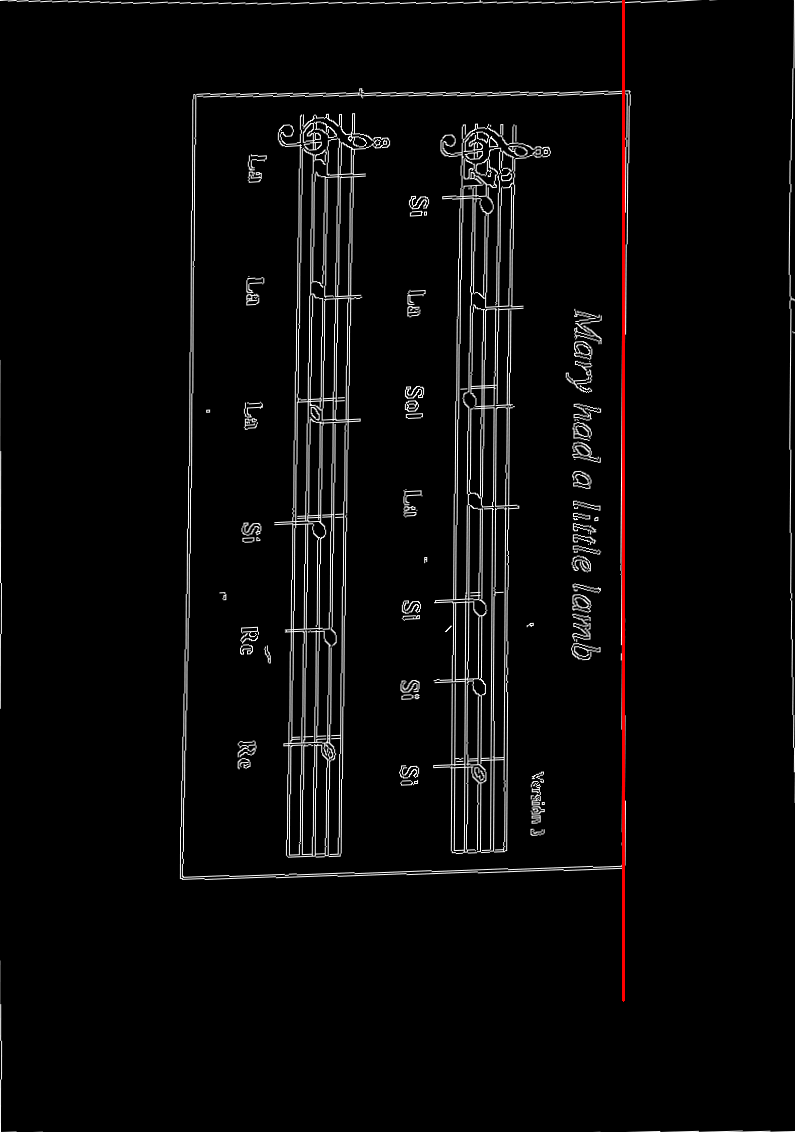

In [ ]:
cv2_imshow(auxImH)

In [ ]:
cv2.imshow("Holo", auxImH) 
#waits for user to press any key  
#(this is necessary to avoid Python kernel form crashing) 
cv2.waitKey(0)  
#closing all open windows  
cv2.destroyAllWindows()

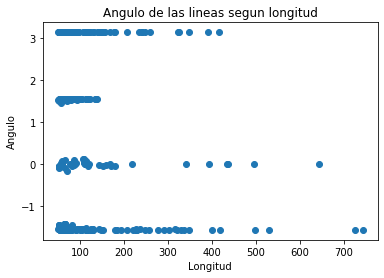

In [ ]:
x_aux = dfPorLongitud["Longitud"]
y_aux = dfPorLongitud["Angulo"]
#plt.plot(x_aux, y_aux, 'o', label = "Plox")
plt.plot(x_aux, y_aux, 'o')
plt.xlabel('Longitud')
plt.ylabel('Angulo')
plt.title('Angulo de las lineas segun longitud')
#plt.legend()
plt.show()

(array([210.,  40.,  16.,   8.,   7.,   5.,   3.,   0.,   1.,   2.]),
 array([50.0, 119.3113719426576, 188.6227438853152, 257.9341158279728,
        327.2454877706304, 396.556859713288, 465.8682316559456,
        535.1796035986032, 604.4909755412608, 673.8023474839184,
        743.113719426576], dtype=object),
 <a list of 10 Patch objects>)

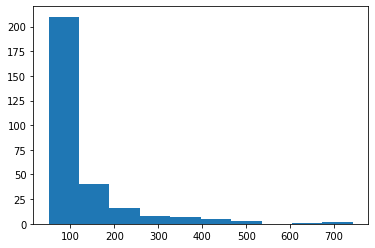

In [ ]:
plt.hist(x_aux)

(array([106.,   0.,   1.,  43.,   0.,   0.,  57.,   0.,   0.,  85.]),
 array([-1.5619470002786389, -1.0915930348917957, -0.6212390695049523,
        -0.15088510411810896, 0.3194688612687342, 0.7898228266555773,
        1.260176792042421, 1.730530757429264, 2.2008847228161073,
        2.671238688202951, 3.141592653589793], dtype=object),
 <a list of 10 Patch objects>)

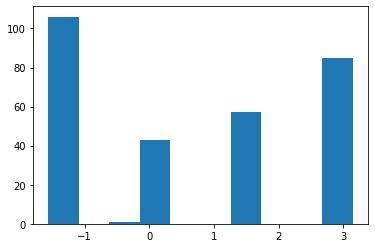

In [ ]:
plt.hist(y_aux)

In [ ]:
def BinningFreq(arr,n): #Se asume recibe matriz de dos dimensiones (Componente i de una imagen) 
    piv = len(arr)//n
    arrPiv = []
    for i in range(1,n):
        arrPiv.append(i*piv)
    arrPiv.append(len(arr))
    arreglo = []
    bins_aux = []
    previo = 0
    for piv in arrPiv:
        bins_aux = arr[previo:piv]
        arreglo.append(bins_aux)
        previo = piv
    return arreglo

In [ ]:
#def graficarTest(variableValores,nombreVar,errorSuma,errorCant,titulo):
#  plt.plot(variableValores, errorSuma, label = "Error en suma")
#  plt.plot(variableValores, errorCant, label = "Error en número de monedas")
#  plt.xlabel(nombreVar)
#  plt.ylabel('Error')
#  plt.title(titulo)
#  plt.legend()
#  plt.show()

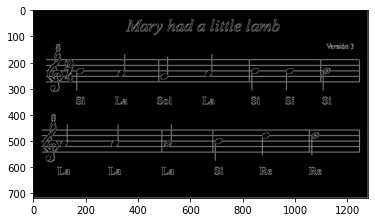

In [ ]:
plt.imshow(r_imIdeal,cmap='gray')

In [ ]:
moda = stats.mode(slopes) #slopes ya no existe, pero es lass pendientesssss
print(moda)

ModeResult(mode=array([-1.]), count=array([85]))


In [ ]:
cv2_imshow(auxIm[113:840,286:301])

In [ ]:
#https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed 
#https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
#sigmaSpace alto podría terminar borrando detalles y no queremos eso porque líneas
#d=3 porque tampoco queremos un blur tan fuerte
imagen = cv2.bilateralFilter(imagen,d=3,sigmaColor=75,sigmaSpace=30)

## Material Bibliográfico

Answers OpenCV ()